# Assignment 3A: Signal Processing and Spectral Analysis
Please submit this assignment to Canvas as a jupyter notebook (.ipynb).  The assignment will introduce you to how to do spectral analysis of EEG timeseries data.

In [1]:
# imports
import mne
import cmlreaders as cml
import numpy as np
import matplotlib.pyplot as plt
from ptsa.data.filters import morlet
from ptsa.data.filters import ButterworthFilter

## Spectral Analysis
Besides ERPs, the primary way neuroscientists understand EEG signals is to look for oscillations, or rhythmic fluctations in the voltage of an EEG signal. Some fluctuations occur very fast, cycling dozens of times in the span of a second, while others will see only 3 or 4 cycles a second. Breaking down EEG according to the contributions of oscillations at various frequencies is key to electrophysiological analysis. 

There are many ways to break down an EEG signal into its component frequencies and measure the contribution of each. During lecture we introduced the Fourier Transform as the foundational tool for spectral analysis, and described the Morelet wavelet method for analyzing time-frequency information. In this assignment, you'll implement some of the techniques discussed in lecture and get an introduction to MNE, a software package for analyzing neural timeseries data.

<center>
<img src="http://neurosky.com/wp-content/uploads/2015/05/Screen-Shot-2015-05-14-at-10.41.17-AM.png" width=300>
</center>

Here's a few tips to keep in mind as you're analyzing spectral power in EEG signals: 

* We're often interested in **contrasts between conditions**, e.g. rememebered vs. not-remembered, or stimulus vs. baseline, etc. Interpreting raw power values can be difficult and should be done with care. 
* Many filters, like the Morlet wavelet, induce edge effects. Be sure to add an appropriately-sized **buffer** and remove it after filtering!
* **Line noise** and harmonics (60 Hz, 120 Hz) can contaminate analyses of high-frequency activity. Re-referencing can mitigate it somewhat, but either avoid analyzing frequencies around 60 and 120 Hz or apply a notch filter to remove residual line noise. 
* **Nyquist limit**: The maximum frequency that can be resolved is equal to the sampling rate divided by two (F_s/2). Subjects are often sampled at 500 Hz or 1000 Hz, corresponding to maximum resolved frequencies of 250 Hz or 500 Hz. In practice, try not to get too close to the limit anyway. This is typically not an issue for any recent subjects, since our maximum frequency of interest is rarely >200 Hz or so.
* **Bandwidth**: The lowest frequency that can be resolved in a timeseries, equal to 1/T, where T is the duration of the available time window. (Same as the smallest-possible frequency spacing.)
* There is a **fundamental trade-off** between time resolution and frequency resolution. With greater frequency resolution comes worse time resolution, and vice versa. So resolving frequencies within ~1 Hz of each other, like in the theta range, is possible, but you will not be able to make judgments about the timing of effects beyond ~1 second. Try to use time windows that contain at least **3 cycles** of your lowest frequency of interest. 
* In the figure below, samples (squares) of various signals (curves) are shown. Subfigure d. shows an example of aliasing, in which a frequency component above the Nyquist limit spuriously appears as a lower frequency component in the set of discrete-time samples.
<center>
<img src="https://github.com/esolomon/PythonBootcamp2019/blob/master/figures/nyquist.png?raw=true" width=700>
</center>

## Implementing time-frequency analyses in Python

There are several Python toolboxes that have good implementations of various spectral decomposition methods. Here we'll focus on **MNE Python** (MNE: MEG 'n' EEG; MEG is similar to scalp EEG but uses magnetic signals rather than electrical ones), a suite of tools for analysis of neural timeseries data (https://martinos.org/mne/stable/index.html). **PTSA** (Python Time Series Analyis) is another Python-based timeseries toolbox, designed by former members of the Computational Memory Lab, that features a very fast implementation of the Morlet Wavelet Transform. (https://github.com/pennmem/ptsa)

### MNE Python
Let's take a look at doing some basic spectral analyses with MNE. First, we'll load up the same dataset we've been working with the past few assignments. 

In [2]:
# We load the dataframe for all sessions.
df = cml.get_data_index()

# Specify which subject and experiment we want
sub = 'R1111M'
exp = 'FR1'

# Select the dataframes for our subject and experiment.
df_select = df[(df['subject']==sub) & (df['experiment']==exp)]
# Pick the first session
df_sess = df_select.iloc[0]

# For first session...
reader = cml.CMLReader(subject=df_sess['subject'], experiment=df_sess['experiment'], session=df_sess['session'],
                       localization=df_sess['localization'], montage=df_sess['montage'])
evs = reader.load("events")
word_evs = evs[evs['type']=='WORD']


In [3]:
# Load the EEG as an mne object.
eeg = reader.load_eeg(evs, rel_start=0, rel_stop=1000).to_mne()
# Select all word events.
eeg = eeg[word_evs.index]
# Select the 62nd electrode.
eeg = eeg.pick(eeg.ch_names[62:63])

/home1/hherrema/.conda/envs/bids/lib/python3.11/site-packages/cmlreaders/readers/eeg.py:563: UserWarning: Some events have eegoffset < 0 and will be dropped.
  warnings.warn("Some events have eegoffset < 0 and will be dropped.")


Not setting metadata
764 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 24 columns


The basis of MNE is the **EpochsArray** structure. It's a Python object that nicely wraps up pertinent information about an EEG-type timeseries, including channel names, sample rates, and event information. Note how our eeg object has information about events and time, among others. It also supports more advanced functionality like filtering, re-referencing, and channel rejection, which we won't get into right now.

**(Tip: MNE functions can often take raw numpy arrays just as well as an EpochsArray -- just be sure you've got the array dimensions right!)**

In [4]:
# what is the eeg object?
eeg?

Type:        EpochsArray
String form:
<EpochsArray |  288 events (all good), 0 – 0.998 s, baseline off, ~1.1 MB, data loaded, with metadata,
 '1': 288>
Length:      288
File:        ~/.conda/envs/bids/lib/python3.11/site-packages/mne/epochs.py
Docstring:  
Epochs object from numpy array.

Parameters
----------
data : array, shape (n_epochs, n_channels, n_times)
    The channels' time series for each epoch. See notes for proper units of
    measure.

info : mne.Info
    The :class:`mne.Info` object with information about the sensors and methods of measurement. Consider using :func:`mne.create_info` to populate this
    structure.
events : None | array of int, shape (n_events, 3)
    The events typically returned by the read_events function.
    If some events don't match the events of interest as specified
    by event_id, they will be marked as 'IGNORED' in the drop log.
    If None (default), all event values are set to 1 and event time-samples
    are set to range(n_epochs).
tmin : f

In [5]:
sfreq = eeg.info['sfreq']    # samplinq frequency (samples/s)
sfreq

500.0

In [6]:
#Let's take a look at the average power spectrum across these events (Welch's method)
psds, freqs = mne.time_frequency.psd_array_welch(eeg._data, sfreq, fmin=3, fmax=150)  #the output is size (events x channels x freqs)

Effective window size : 0.512 (s)


Text(0.5, 0, 'Frequency (Hz)')

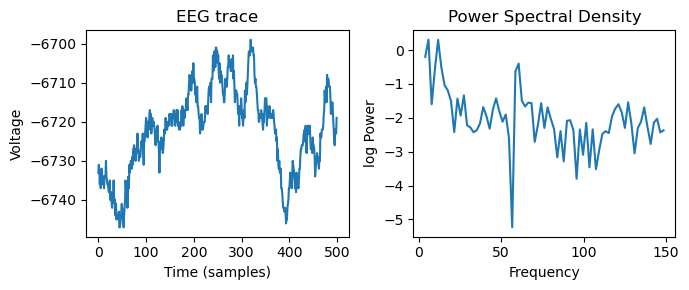

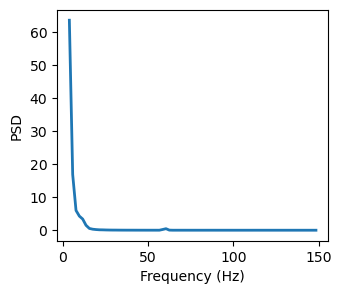

In [7]:
# Plot our results
%matplotlib inline

# Plot individual trial example
plt.figure(figsize=(7, 3))
ax = plt.subplot(121);
plt.plot(eeg.get_data()[10, 0, :])
plt.title('EEG trace')
plt.xlabel('Time (samples)')
plt.ylabel('Voltage')
ax = plt.subplot(122);
plt.plot(freqs, np.log10(psds[10, 0, :]))
plt.title('Power Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('log Power')
plt.tight_layout()

# Average PSD without log-normalization
plt.figure(figsize=(3.5, 3))
ax = plt.subplot(111)
plt.plot(freqs, np.mean(psds[:, 0, :], 0), linewidth=2)
plt.ylabel('PSD')
plt.xlabel('Frequency (Hz)')

Note how the power at high frequencies is significantly smaller than at low frequencies. This is a classic relationship found in many natural signals, called the **"1/f"** phenomenon. It means that the amplitude of high-frequency signals tends to be much smaller than the amplitude of low-frequency signals. 

Unfortunately, this relationship makes it difficult to visualize changes at high frequencies, or properly assess differences between frequency bands. This is one reason why people often take the log of power values before going forward with analyses. Another reason is to transform non-normally distributed units of power (which are non-negative) to log-power, which are less drasatically non-normal.

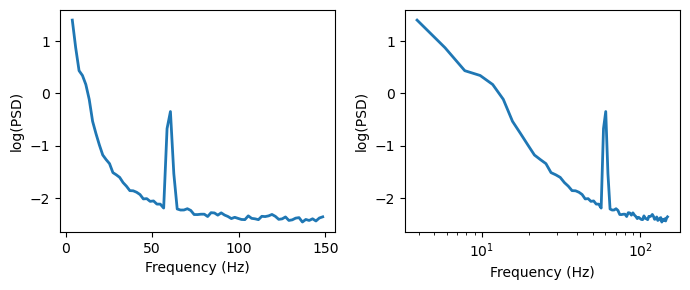

In [8]:
log_psds = np.log10(psds)

plt.figure(figsize=(7, 3))
ax = plt.subplot(121)
plt.plot(freqs, np.mean(log_psds[:, 0, :], 0), linewidth=2)
plt.ylabel('log(PSD)')
plt.xlabel('Frequency (Hz)');

# Plot on a log axis to better see low frequencies
ax = plt.subplot(122)
plt.semilogx(freqs, np.mean(log_psds[:, 0, :], 0), linewidth=2)
plt.ylabel('log(PSD)')
plt.xlabel('Frequency (Hz)');

plt.tight_layout()  #This cleans up our plots a bit

That's much better! We can better see things going on at all points throughout our frequency range. Note that there are several other ways to normalize power values -- some of which we will discuss -- that can also be applied after an initial log transform.

Now let's analyze 3 seconds of the power sectrum of the first channel for subject R1292E. What do you notice?

Not setting metadata
312 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 29 columns
Effective window size : 0.256 (s)


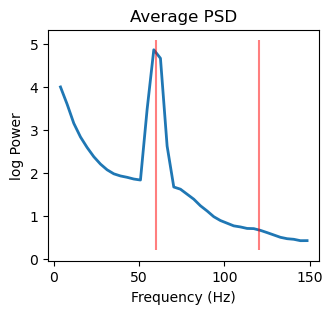

In [9]:
# Where's the primary noise component?
sub = 'R1292E'
exp = 'FR1'
df_select = df[(df['subject']==sub) & (df['experiment']==exp)]
df_sess = df_select.iloc[0]
reader = cml.CMLReader(subject=df_sess['subject'], experiment=df_sess['experiment'], session=df_sess['session'],
                       localization=df_sess['localization'], montage=df_sess['montage'])
evs = reader.load("events")
word_evs = evs[evs['type']=='WORD']
# Load the EEG as an mne object with word events only
eeg = reader.load_eeg(word_evs, rel_start=0, rel_stop=3000).to_mne()
# Select the 62nd electrode.
eeg = eeg.pick(eeg.ch_names[0:1])
sfreq = eeg.info['sfreq']
psds, freqs = mne.time_frequency.psd_array_welch(eeg._data, sfreq, fmin=3, fmax=150)  #the output is size (events x channels x freqs)

plt.figure(figsize=(3.5, 3))
ax = plt.subplot(111)
plt.plot(freqs, np.log10(np.mean(psds[:, 0, :], 0)), linewidth=2)
plt.title('Average PSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('log Power')
plt.vlines([60, 120], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='red', alpha=0.5)

Removed notch frequencies (Hz):
     60.00 :  312 windows
    120.00 :  312 windows
Effective window size : 0.256 (s)


Text(0.5, 1.0, 'Notch Filtered Data')

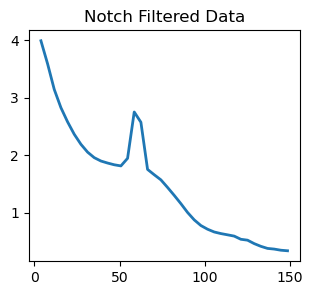

In [10]:
# Filtering out the noise and its harmonic

# spectrum_fit method
filt_data = mne.filter.notch_filter(eeg.get_data(), Fs=eeg.info['sfreq'], freqs=[60, 120],
                                    method='spectrum_fit')

# Get power spectral densities
# the output is size (events x channels x freqs)
psds, freqs = mne.time_frequency.psd_array_welch(filt_data, sfreq=eeg.info['sfreq'],
                                                 fmin=3, fmax=150)

plt.figure(figsize=(3.5, 3))
ax = plt.subplot(111)
plt.plot(freqs, np.log10(np.mean(psds[:, 0, :], 0)), linewidth=2)
plt.title('Notch Filtered Data')

Another alternative method is to use ptsa.data.filters.ButterworthFiler() in a similar manner. Read that function's documentation for details: https://pennmem.github.io/ptsa/html/api/data/filters.html.

### Wavelet transform 
The wavelet transform is a powerful spectral decomposition method, since it explicitly lets us observe changes in the power spectrum over time. However, because this method involves convolving wavelets with our timeseries, we need to be sure to add buffers to either end of the signal (which we can clip off later). Otherwise, we'll end up eith edge effects that contaminate our results.

Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 24 columns


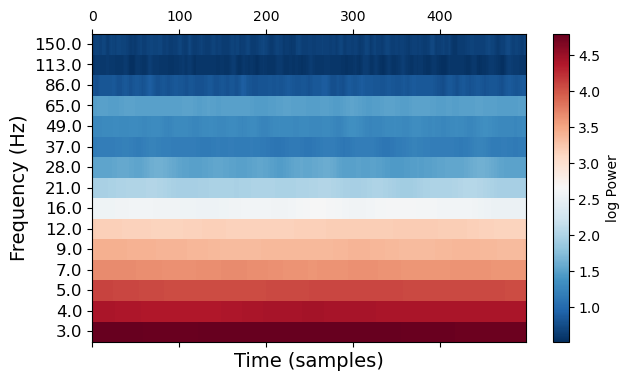

In [11]:
##### Load EEG

buf = 1000  #define the buffer (in ms) here. Should be at least half the total wavelet length at lowest frequency (i.e. 1/2f * n_cycles). With standard params, 1 sec usually suffices. 

# We load the dataframe for all sessions.
df = cml.get_data_index()

# Specify which subject and experiment we want
sub = 'R1111M'
exp = 'FR1'

# Select the dataframes for our subject and experiment.
df_select = df[(df['subject']==sub) & (df['experiment']==exp)]
# Pick the first session
df_sess = df_select.iloc[0]

# For first session...
reader = cml.CMLReader(subject=df_sess['subject'], experiment=df_sess['experiment'], session=df_sess['session'],
                       localization=df_sess['localization'], montage=df_sess['montage'])
evs = reader.load("events")
word_evs = evs[evs['type']=='WORD']

# Load the EEG as an mne object.
eeg = reader.load_eeg(word_evs, rel_start=-buf, rel_stop=1000+buf).to_mne()
# Select the 62nd electrode.
eeg = eeg.pick(eeg.ch_names[62:63])

sr = eeg.info['sfreq'] #we'll need this soon

# Pre-define an array of frequencies.
# We can log-space them since wavelets are less sensitive to differences at higher frequencies
myfreqs = np.logspace(np.log10(3), np.log10(150), num=15)

# Run TF decomposition
# We're setting it to automatically average across trials
power = mne.time_frequency.tfr_morlet(eeg, freqs=myfreqs, n_cycles=5, return_itc=False, average=True)

# Plot results
plt.figure(figsize=(7., 4))
ax = plt.subplot(111)
# We're cutting off the buffers manually here
plt.matshow(np.log10(power.data[0, :, int(buf/1000.*sr):-1*int(buf/1000.*sr)]), fignum=0, aspect='auto', cmap='RdBu_r')
ax.invert_yaxis()
plt.yticks(np.arange(0, len(myfreqs)), np.round(myfreqs), fontsize=12)
plt.xlabel('Time (samples)', fontsize=14)
plt.ylabel('Frequency (Hz)', fontsize=14)
cb = plt.colorbar()
cb.set_label('log Power',)

This is nice, but we're not seeing much interesting activity because our color scale is still getting squished by the **overall** difference between low and high frequency power (despite our log transform). One way to address this is to normalize the data **within** each frequency by z-scoring across events. This will become important for future assignments when we discuss multivariate machine learning methods for analyzing this data.

Adding metadata with 24 columns


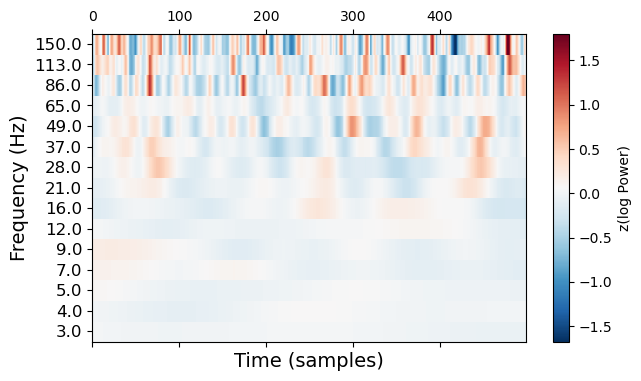

In [12]:
# Re compute power without averaging over events
power = mne.time_frequency.tfr_morlet(eeg, freqs=myfreqs, n_cycles=5, return_itc=False, average=False)

# Create an array of the mean and standard deviation of the power values across the session
power_data = power.data[:,:,:,int(buf/1000.*sr):-1*int(buf/1000.*sr)]
m = np.mean(np.mean(power_data,axis=3),axis=0)
m = np.expand_dims(np.expand_dims(m,axis=0),axis=3)
m = np.repeat(np.repeat(m,word_evs.shape[0],axis=0),power_data.shape[-1],axis=3)

sd = np.std(np.mean(power_data,axis=3),axis=0)
sd = np.expand_dims(np.expand_dims(sd,axis=0),axis=3)
sd = np.repeat(np.repeat(sd,word_evs.shape[0],axis=0),power_data.shape[-1],axis=3)

zpower_data = (power_data-m)/sd
zpower_data.shape

# Plot results
plt.figure(figsize=(7., 4))
ax = plt.subplot(111)
plt.matshow(np.mean(zpower_data[:,0, :,:],axis=0), fignum=0, aspect='auto', cmap='RdBu_r')
ax.invert_yaxis()
plt.yticks(np.arange(0, len(myfreqs)), np.round(myfreqs), fontsize=12)
plt.xlabel('Time (samples)', fontsize=14)
plt.ylabel('Frequency (Hz)', fontsize=14)
cb = plt.colorbar()
cb.set_label('z(log Power)',)

### Spectral Analysis in PTSA
The PTSA library was developed by the Computational Memory Lab to implement several key transforms useful in memory analysis. In particular, PTSA proides a fast implementation of the Morlet wavelet filter. Also relevant is its implementation of the Butterworth filter.

In [13]:
# load EEG

sub = 'R1123C'
from cmlreaders import get_data_index, CMLReader
df = get_data_index('r1', '/')

range_left_ms = 1000
range_right_ms = 2000
morlet_reps = 6

df_sub = df.query('subject == @sub and experiment == "FR1"').iloc[:1]
reader = CMLReader(subject=sub, session=df_sub.session.item(), experiment=df_sub.experiment.item(),
                   localization=df_sub.localization.item(), montage=df_sub.montage.item())
pairs = reader.load('pairs')
evs = reader.load('events')
enc_evs = evs[evs.type=='WORD'].iloc[:25]

eeg = reader.load_eeg(events=enc_evs, rel_start=-range_left_ms, \
                      rel_stop=range_right_ms, scheme=pairs)

eeg_ptsa = eeg.to_ptsa()

In [14]:
eeg_chan = eeg_ptsa.sel(channel=['TO8-TO9', 'OF3-OF4'])
freqs = np.unique(np.logspace(np.log10(1), np.log10(300), 72))

# compute spectral features!
wf = morlet.MorletWaveletFilter(freqs=freqs, width=morlet_reps, output='power', complete=True)
# freqs, events, elecs, and time
powers = wf.filter(eeg_chan)

# remove buffers
powers = powers.isel(time=powers.time>0)
powers = powers.isel(time=powers.time<1000)

CPP total time wavelet loop:  0.14664745330810547


In [15]:
powers.dims

('frequency', 'event', 'channel', 'time')

In [16]:
powers.shape

(72, 25, 2, 499)

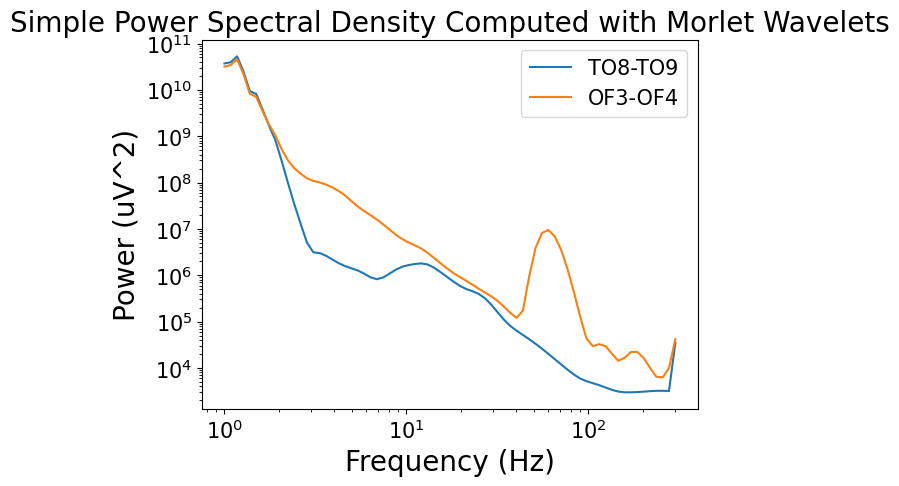

In [17]:
# compute simple PSD by averaging over time and events
psd = powers.mean('time').mean('event')
for chan in psd.channel:
    plt.loglog(psd.frequency, psd.sel(channel=chan), label=chan.item())

plt.legend(fontsize=15)
plt.title('Simple Power Spectral Density Computed with Morlet Wavelets', fontsize=20)
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.ylabel('Power (uV^2)', fontsize=20)
_ = plt.xticks(fontsize=15)
_ = plt.yticks(fontsize=15)

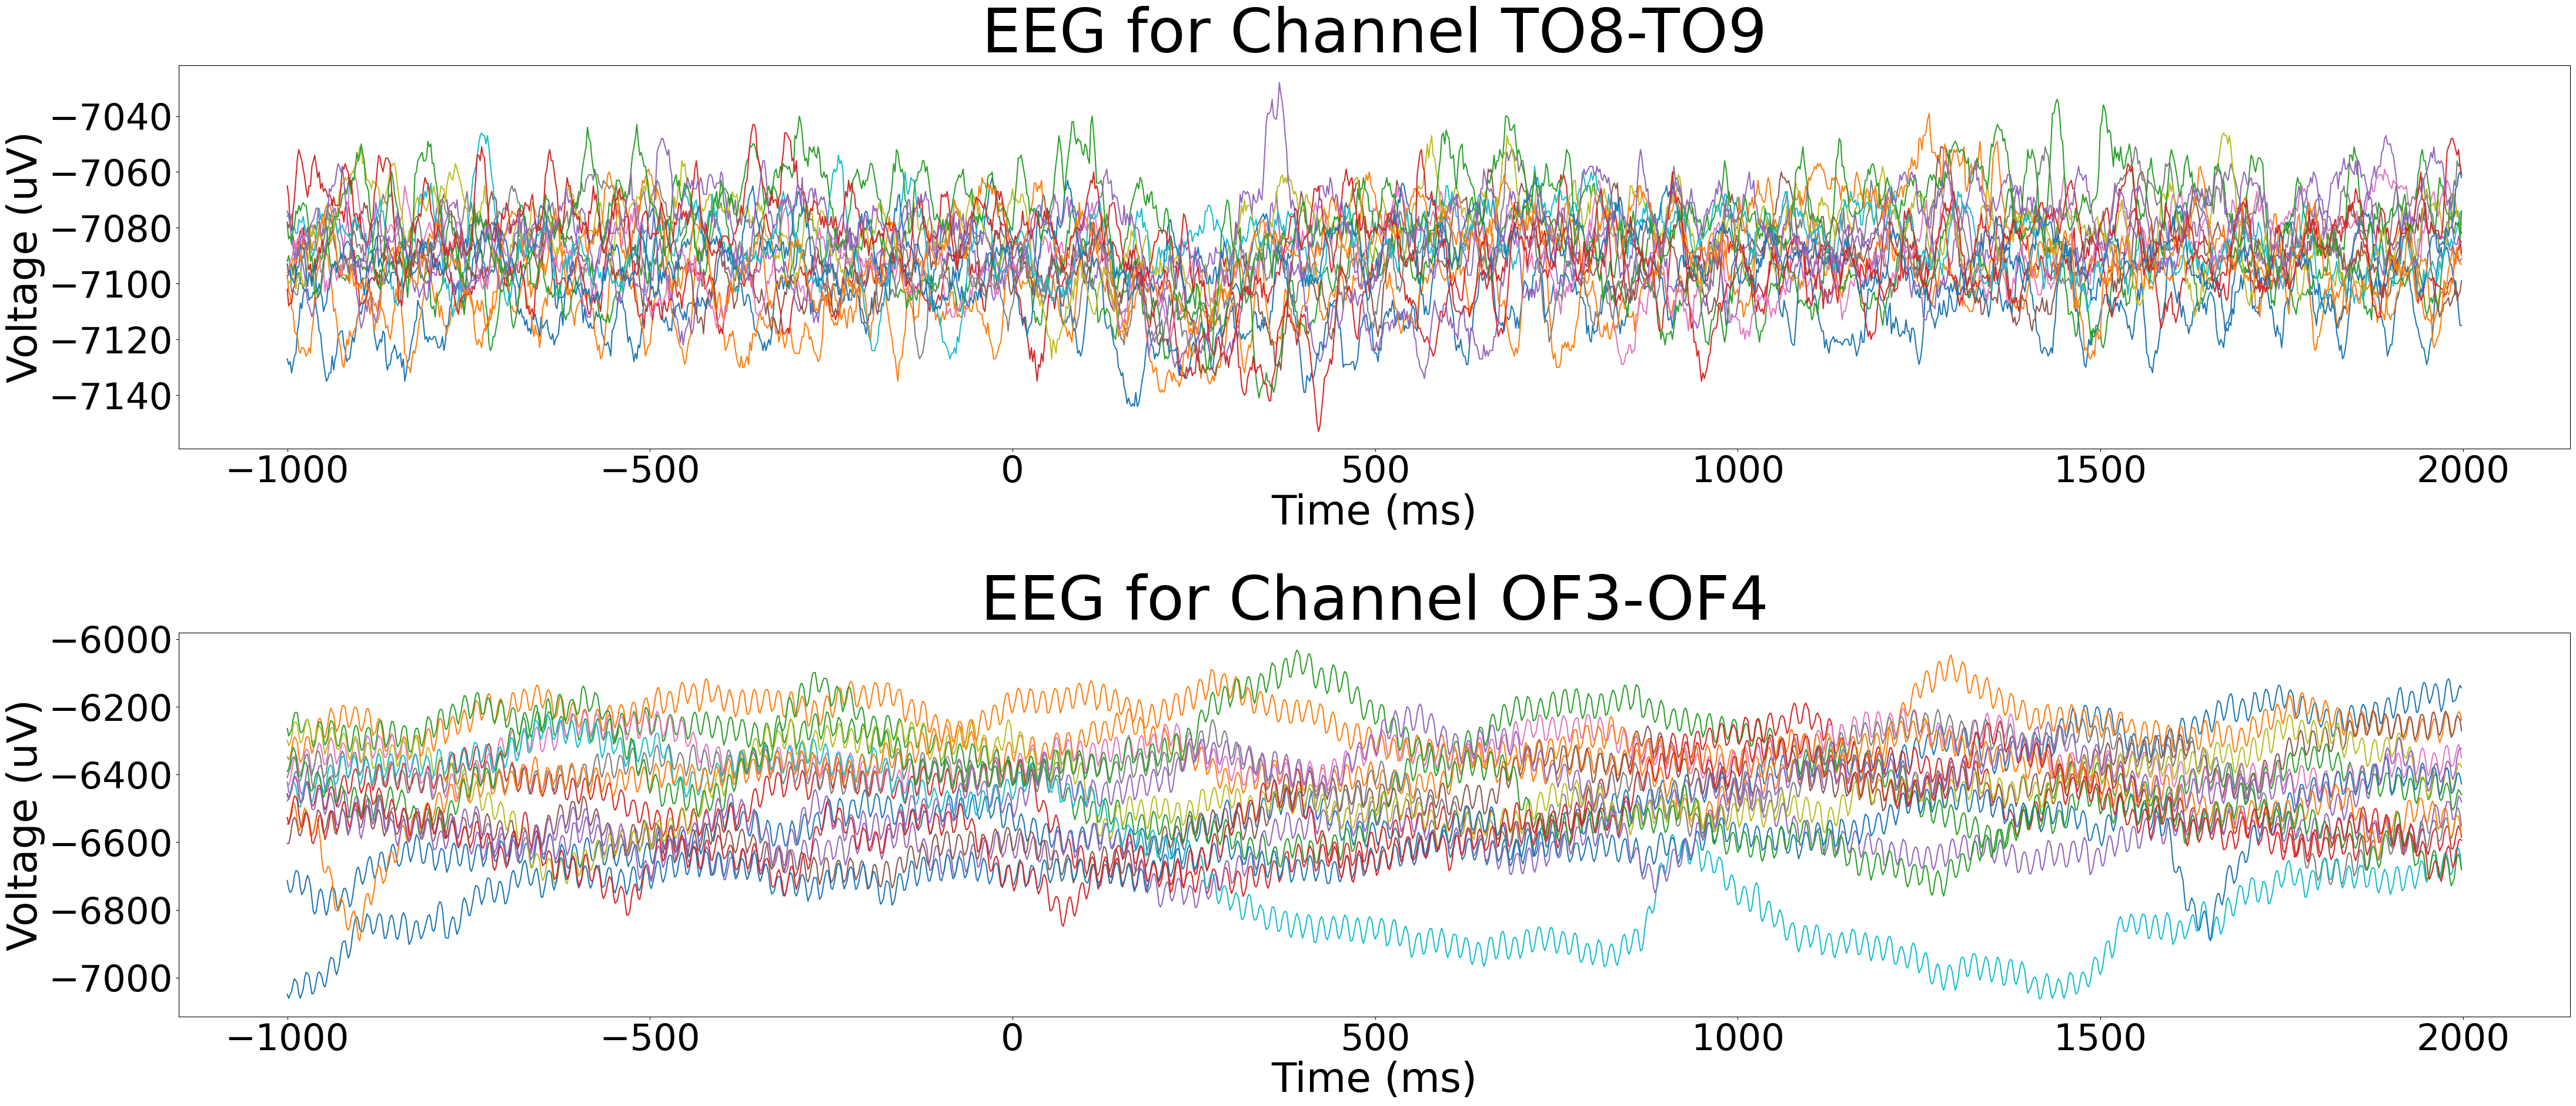

In [18]:
fig = plt.figure(figsize=(45, 20))
for i, ch in enumerate(eeg_chan.channel):
    eeg_ch = eeg_chan.sel(channel=ch)
    plt.subplot(2, 1, i + 1)
    plt.title(f'EEG for Channel {ch.item()}', fontsize=75)
    plt.xlabel('Time (ms)', fontsize=50)
    plt.ylabel('Voltage (uV)', fontsize=50)
    plt.xticks(fontsize=45)
    plt.yticks(fontsize=45)
    # plot traces
    for ev in eeg_ch.event[:15]:
        plt.plot(eeg_ch.time, eeg_ch.sel(event=ev))
fig.tight_layout(pad=5.0)

CPP total time wavelet loop:  0.1651914119720459


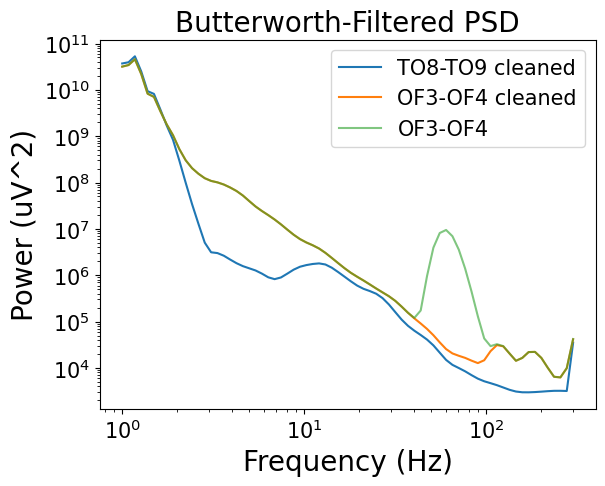

In [19]:
# clean up line noise at 60 Hz from power grid just as before, but with PTSA
freq_range = [58., 62.]
b_filter = ButterworthFilter(freq_range=freq_range, filt_type='stop', order=4)
eeg_filtered = b_filter.filter(eeg_chan)

# compute spectral features!
wf = morlet.MorletWaveletFilter(freqs=freqs, width=morlet_reps, output='power', complete=True)
# freqs, events, elecs, and time
powers = wf.filter(eeg_filtered)

# remove buffers
powers = powers.isel(time=powers.time>0)
powers = powers.isel(time=powers.time<1000)

psd_filtered = powers.mean('time').mean('event')
for chan in psd.channel:
    plt.loglog(psd_filtered.frequency, psd_filtered.sel(channel=chan), label=chan.item() + ' cleaned')
plt.loglog(psd.frequency, psd.sel(channel='OF3-OF4'), label=chan.item(), alpha=0.6)

plt.legend(fontsize=15)
plt.title('Butterworth-Filtered PSD', fontsize=20)
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.ylabel('Power (uV^2)', fontsize=20)
_ = plt.xticks(fontsize=15)
_ = plt.yticks(fontsize=15)

## Question 1
Let's just get some practice going from raw EEG to a power spectral density analysis.  We will use R1215M's first FR1 session, and will focus on the electorde pair 'LAST1-LAST2'. 

1) Analyzing the 100ms before to 1000ms after each word encoding event, separately plot the log power spectral densities for subequently recalled and subsequently not recalled words.
* Load the EEG data with a 1000ms buffer from the desired channel.
* Filter out 60 Hz line noise with a Butterworth Filter.
* Separate recalled and non-recalled words.
* Apply morlet wavelets to calculate powers at the frequencies given below.
* Remove the buffers.
* Average across encoding time interval and events.
* Plot log power v. frequency, label recalled and non-recalled.

In [31]:
freqs = np.round(np.logspace(np.log10(3), np.log10(180), 8))
buf = 1000
channel = 'LAST1-LAST2'
subj = 'R1215M'
exp = 'FR1'
sess = 0

In [32]:
# Question 1.1

### YOUR CODE HERE